#  Face recognition through Eigenfaces

The goal of this exercise is to have a good performing model for face recognition using Eigenfaces. This technique was often used in the earliest of computer vision techniques to perform face recognition.
By now, Eigenfaces have been replaced by techniques based on convolutional neural networks.

Here we have a dataset that is already split up into a training and test set. The faces are coming from 50 different people and each person has 15 pictures original data: http://www.anefian.com/research/face_reco.htm

Some preprocessing has already been performed like cropping and rotation.

From the filename of each picture, the persons ID can be determined. E.g. person22_15.jpg is the 15th picture of the 22th person.

Goals of this exercise:
* Read in the images and extract the ID of the person from the filenames
* Convert the image to black and white
* Scale the images to the same size (150x110)
* Transform the data so the images are converted to a single array of all pixel values
* Convert the faces to eigenfaces using PCA
* Train different types of classifiers on the PCA data, also perform some hyperparameter tuning and/or ensemble learning
* Test and compare the classifiers

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
import seaborn as sns
import matplotlib.image as mpimg
from skimage import transform
from scipy import ndimage
from skimage.io import imread, imshow
from sklearn import linear_model, datasets
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Read in the training images
training_images = []# empty list
test_images = [] # empty list
y_train = [] # empty list
y_test = [] # empty list

path = "./Faces/Training_images/"
for f in os.listdir(path):
    training_images.append(imread(os.path.join(path,f), as_gray=True))
    y_train.append(int(f[6:8]))

path = "./Faces/Test_images/"
for f in os.listdir(path):
    test_images.append(imread(os.path.join(path,f), as_gray=True))
    y_test.append(int(f[6:8]))
    
# To list files in a directory you can use os.listdir("path here")
# y_train and y_test will have to be parsed from the filename (e.g. person01_02_.jpg -> 1 (or 01), person13_05_.jpg -> 13)
# Reading in the images can be done using the imread() function from skimage.io: https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread
# Note the parameter as_gray in this function. Use this to convert the image to black and white.
# The result will be a 2D array that  contains all the pixel values between 0 and 1

In [27]:
f=os.listdir(path)[0]
f.split("_")[0][6:]

print("number for training images", len(training_images))
print("number for test images", len(test_images))

print("unique peaople in trainingset", len(set(y_train)))
print("unique peaople in trainingset", len(set(y_test)))

number for training images 500
number for test images 250
unique peaople in trainingset 50
unique peaople in trainingset 50


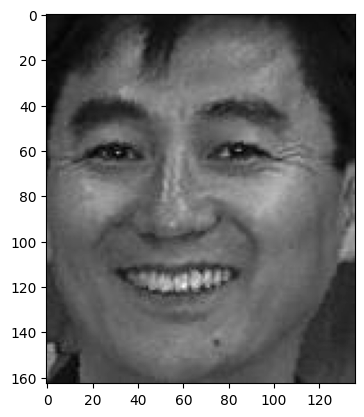

In [28]:
# Show a single image using plt.imshow(image,cmap='gray')
# Image is the result of the imread you used above
plt.imshow(training_images[90], cmap='gray')

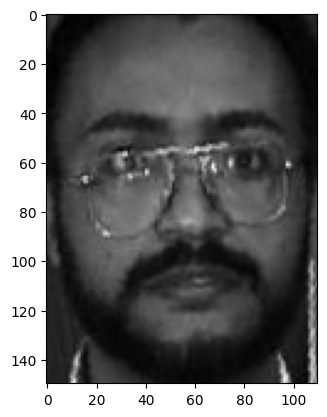

In [69]:
# Resize the images to 150 rows * 110 columns
# Use the transform.resize function from skimage with mode=constant
# https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
from skimage import data

from skimage.transform import resize
for image in training_images:
    image = resize(image, (150,110))
    training_images_reshaped = []
    training_images_reshaped.append(image)
for image2 in test_images:
    image2 = resize(image2, (150, 110))
    test_images_reshaped = []
    test_images_reshaped.append(image2)

plt.imshow(training_images_reshaped[0],cmap='gray')

In [71]:
#option two 
training_images_resized = [transform.resize(image, (150,110), mode="constant") for image in training_images]
test_images_resized = [transform.resize(image, (150,110), mode="constant" ) for image in test_images]

training_images_resized[90].shape

(150, 110)

In [81]:
training_images_resized[90].shape
[[px1,px2,px3,...]
[px111,px112...]
...
]
[f1,f2,f3,f4...150*110]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (633661097.py, line 3)

In [73]:
# Reshape the images to a single dimension using the reshape function
# Note: https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html
training_images_1d = [image.reshape(-1) for image in training_images_resized]
test_images_1d = [image.reshape(-1) for image in test_images_resized]

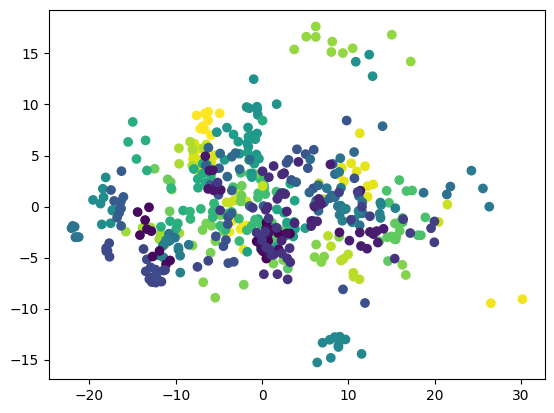

In [74]:
# Dimensionality reduction: Perform Principle Component Analysis with 40 components
# Train the PCA algorithm on the training data
# Transform both the training and the test set to 40 components; Hint: save into a seperate variable
from sklearn.decomposition import PCA

# Create a PCA model with 2 components (instead of the 7 features of the dataset)
number_of_components =40
PCA_model = PCA(n_components=number_of_components)

X_training_images_PCA = PCA_model.fit_transform(training_images_1d)
X_test_images_PCA = PCA_model.transform(test_images_1d) #no fitting on the test

plt.scatter(training_images_PCA[:,0], training_images_PCA[:,1], c=y_train)

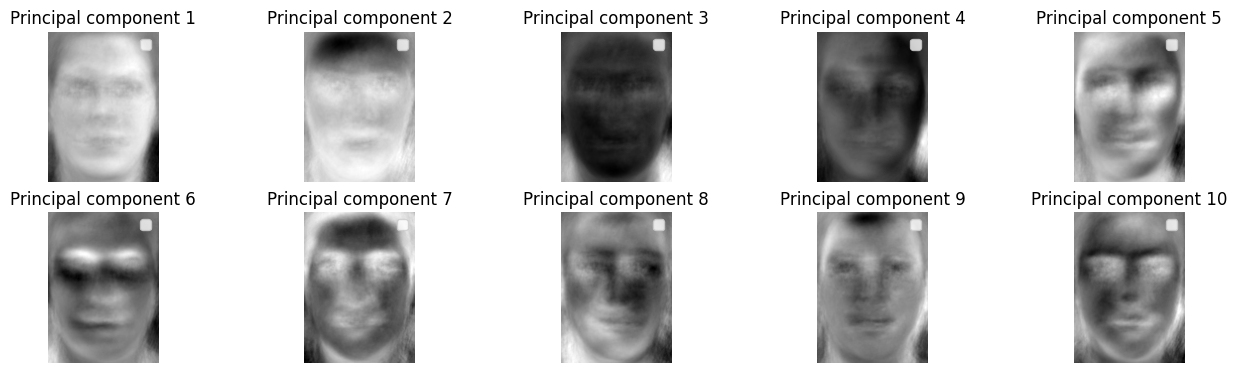

In [75]:
# Visualize 10 principle components (the 10 first Eigenfaces)
# Get the values for the principal components
PCA_components = PCA_model.components_

fig = plt.figure(figsize=(16, 9)) 
for i in range(0,10):
    ax = fig.add_subplot(4, 5, i+1)
    plt.imshow(PCA_components[i].reshape((150,110)),cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axis('off')
    plt.legend('off')
    
    ax.set_title('Principal component '+str(i+1))
    # x and y axis should be equal length
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
plt.show()

In [76]:
# Show the PCA values for a single face
# What do these values represent?
test_images_PCA[0]

training_images_PCA[0]
#one face now is fourty values, Each value  is the factor of each image above, substract them all and you get the original image. 

array([-2.56679899e+00,  6.78260253e-01, -3.48653527e+00,  7.01349915e+00,
        8.32823070e-01,  1.49077267e+00, -1.53591229e-04, -3.18355174e-01,
        5.37592501e-01,  2.17937456e+00,  3.47569915e+00, -2.85355002e+00,
       -4.81455156e+00,  5.32552719e-01,  3.14272944e+00, -1.45247291e+00,
       -1.50461161e+00,  6.47624176e-01, -3.51354936e+00, -3.90409618e-01,
        1.83607109e+00,  1.40382163e+00, -1.17255488e+00,  8.64297318e-01,
        1.42271945e+00, -1.50296757e+00, -5.44977560e-01, -8.82396329e-01,
       -6.91947656e-02, -5.31646323e-01, -1.18610561e+00,  1.85513751e+00,
       -1.49544936e-01, -1.29272230e+00, -5.04988700e-01,  1.39931933e+00,
       -8.23090732e-01, -7.67711944e-02,  3.58668004e-01,  6.88818596e-01])

In [77]:
# Show how much variance is explained in total by the principal components
sum(PCA_model.explained_variance_ratio_)

0.8067661115507646

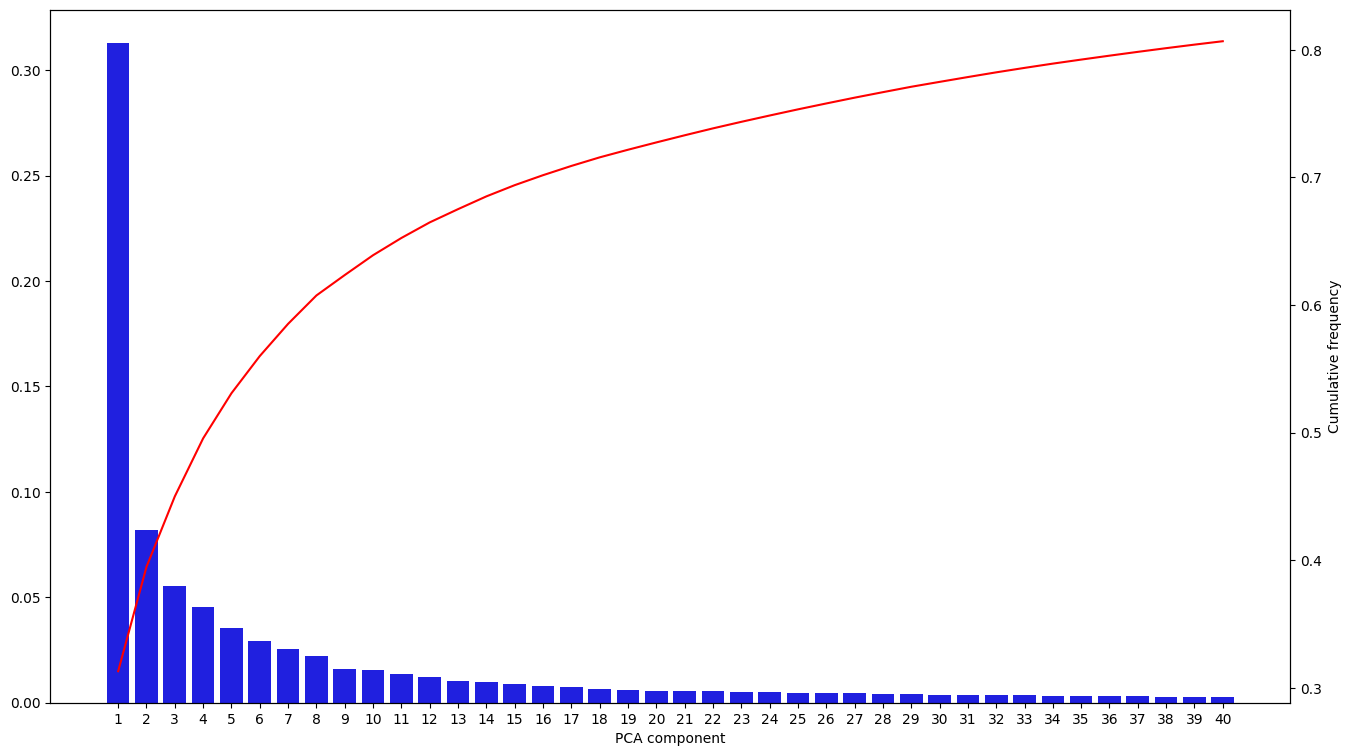

In [78]:
# Generate a combined graph of the explained variance in function of the principal component.
# Barplot for the variance of the single component as well as the cumulative explained variance
import seaborn as sns
PCAnumber = np.arange(1,number_of_components+1)
# The sum of the component + all previouse components
PCA_explained_cumulative = np.cumsum(PCA_model.explained_variance_ratio_)

fig = plt.figure(figsize=(16, 9)) 
ax=sns.barplot(x=PCAnumber,y=PCA_model.explained_variance_ratio_,color='blue')
plt.xlabel('PCA component')
ax2=ax.twinx() # double y-axis
ax.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Cumulative frequency')
plot=plt.plot(PCA_explained_cumulative, c='red')

#EXAM: determine how many components you need to explain 88% of the data -> use the numpy cummulative sum 
#np.cumsum(PCA_model.explained_variance_ratio_) ->need 25 components to get to 0.75

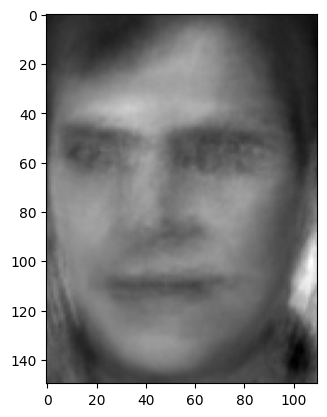

In [79]:
# Try and reconstruct a face using the eigenfaces
reconstructed = PCA_model.inverse_transform(X_training_images_PCA[0])
plt.imshow(reconstructed.reshape(150,110),cmap='gray')

## Classification

Train multiple classifiers of choice (logistic regression, naive bayes, random forest trees, ensembles) for the recognition of the faces. Use the PCA values as features. Perform cross-validation for the optimal hyperparameters.

Also try following things:
* Vary the number of components, what happens when you decrease or increase the number?
* Does the number of components affect the time it takes to train a model?
* Visualize a few wrongly classified faces


In [80]:
lregmodel = LogisticRegressionCV(max_iter=1000, Cs=20, cv=10, multi_class="multinomial", solver='lbfgs')
lregmodel.fit(X_training_images_PCA, y_train)

y_pred = lregmodel.predict(X_test_images_PCA)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 1 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]
              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      0.80      0.89         5
           4       0.44      0.80      0.57         5
           5       1.00      0.60      0.75         5
           6       0.60      0.60      0.60         5
           7       0.83      1.00      0.91         5
           8       1.00      0.80      0.89         5
           9       0.50      0.40      0.44         5
          10       0.83      1.00      0.91         5
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00         5
          13       1.00      0.80      0.89         5
          14       0.80      0.80      0.80         5
          15       1.00      0.80      0.89         5
          16   

### Change the number of components
also take a look at the time it takes for less or more components and the accuracy

In [82]:
%%time

print("Using %%time at the beginning of a cell you can time how long it takes to execute that cell")
# Fill some time
from time import time,sleep
sleep(1)

print("Or you can time pieces of code yourself using time")
start=time()
sleep(1)
print(f"Time taken: {round(time()-start,2)}s")

Using %%time at the beginning of a cell you can time how long it takes to execute that cell
Or you can time pieces of code yourself using time
Time taken: 1.01s
CPU times: user 3.7 ms, sys: 7.31 ms, total: 11 ms
Wall time: 2.02 s


### Some wrongly classified faces
Use your best model from the things you tried above and take a look at the faces that are wrongly classified